# Stage 07 — Outliers & Risk Assumptions (ASML)
IQR / Z-score detection, winsorizing, sensitivity analysis, and assumptions.

In [ ]:
Imports, paths

In [1]:
from __future__ import annotations
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Resolve project root when running from project/notebooks
project_root = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd().resolve()
sys.path.append(str(project_root / "src"))

load_dotenv(project_root / ".env")

from storage import env_paths, read_df, write_df
from outliers import detect_outliers_iqr, detect_outliers_zscore, winsorize_series

RAW_DIR, PROC_DIR = env_paths(project_root)
OUT_DIR = PROC_DIR / "outliers"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def stamp(): return datetime.now().strftime("%Y%m%d-%H%M")
RAW_DIR, PROC_DIR, OUT_DIR


(WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/raw'),
 WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed'),
 WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/outliers'))

Load data & create a returns series

In [2]:
# Prefer cleaned processed file if available, else fall back to latest raw API file
clean_candidates = sorted(PROC_DIR.glob("asml_cleaned_*.parquet")) + sorted(PROC_DIR.glob("asml_cleaned_*.csv"))
raw_candidates = sorted(RAW_DIR.glob("api_*ASML_*.csv"))

if clean_candidates:
    src_path = clean_candidates[-1]
    print("Using CLEANED file:", src_path.name)
    df = read_df(src_path, parse_dates=["date"])
elif raw_candidates:
    src_path = raw_candidates[-1]
    print("Using RAW file:", src_path.name)
    df = read_df(src_path, parse_dates=["date"])
else:
    raise FileNotFoundError("No ASML files found. Run Stage 04/06 first.")

# Build a simple return series (use adjusted_close if present)
price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"
df = df.sort_values("date").reset_index(drop=True)
df["ret"] = df[price_col].pct_change()
df = df.dropna(subset=["ret"]).reset_index(drop=True)

df[["date", price_col, "ret"]].head()


Using CLEANED file: asml_cleaned_20250818-2218.csv


,date,adjusted_close,ret
0,2020-08-18,363.675568,-0.003408
1,2020-08-19,361.477417,-0.006044
2,2020-08-20,358.806976,-0.007388
3,2020-08-21,358.758667,-0.000135
4,2020-08-24,364.417908,0.015775


Detect outliers (IQR + Z-score) and winsorize

In [3]:
iqr_mask, (lb, ub) = detect_outliers_iqr(df["ret"], k=1.5)
z_mask, (mu, sd)   = detect_outliers_zscore(df["ret"], threshold=3.0)
any_mask = iqr_mask | z_mask

ret_win, (ql, qh)  = winsorize_series(df["ret"], lower=0.01, upper=0.99)

print(f"IQR bounds: [{lb:.6f}, {ub:.6f}]  | flagged: {iqr_mask.sum()}")
print(f"Z-score: mu={mu:.6f}, sd={sd:.6f} | flagged: {z_mask.sum()}")
print(f"Any outlier flagged: {any_mask.sum()}")
print(f"Winsorized to quantiles [{ql:.6f}, {qh:.6f}]")

df_flags = df[["date", "ret"]].copy()
df_flags["outlier_iqr"] = iqr_mask.values
df_flags["outlier_z"]   = z_mask.values
df_flags["outlier_any"] = any_mask.values
df_flags["ret_winsor"]  = ret_win.values

df_flags.head()


IQR bounds: [-0.057421, 0.060337]  | flagged: 46
Z-score: mu=0.000906, sd=0.026071 | flagged: 11
Any outlier flagged: 46
Winsorized to quantiles [-0.065780, 0.065199]


,date,ret,outlier_iqr,outlier_z,outlier_any,ret_winsor
0,2020-08-18,-0.003408,False,False,False,-0.003408
1,2020-08-19,-0.006044,False,False,False,-0.006044
2,2020-08-20,-0.007388,False,False,False,-0.007388
3,2020-08-21,-0.000135,False,False,False,-0.000135
4,2020-08-24,0.015775,False,False,False,0.015775


Sensitivity: summary stats table (all / filtered / winsorized)

In [4]:
def summary_stats(x: pd.Series) -> pd.Series:
    return pd.Series({
        "count": x.count(),
        "mean":  x.mean(),
        "median":x.median(),
        "std":   x.std(),
        "min":   x.min(),
        "max":   x.max(),
    })

all_stats       = summary_stats(df_flags["ret"])
filtered_stats  = summary_stats(df_flags.loc[~df_flags["outlier_any"], "ret"])
winsor_stats    = summary_stats(df_flags["ret_winsor"])

sens = pd.concat(
    [all_stats.rename("all"), filtered_stats.rename("filtered_no_outliers"), winsor_stats.rename("winsorized")],
    axis=1
)
sens


,all,filtered_no_outliers,winsorized
count,1255.000000,1209.000000,1255.000000
mean,0.000906,0.001157,0.000820
median,0.000770,0.000795,0.000770
std,0.026081,0.021540,0.024444
min,-0.162610,-0.056571,-0.065780
max,0.154341,0.059507,0.065199


Sensitivity: simple AR(1) regression on returns

In [5]:
def ar1_metrics(ret: pd.Series) -> dict:
    r = ret.dropna().to_numpy()
    if r.size < 3:
        return {"n": r.size, "alpha": np.nan, "beta_lag1": np.nan, "r2": np.nan, "mae": np.nan}
    y = r[1:]
    x = r[:-1]
    X = np.c_[np.ones_like(x), x]  # intercept + lag1
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    resid = y - y_hat
    ss_res = np.sum(resid**2)
    ss_tot = np.sum((y - y.mean())**2) if y.size else np.nan
    r2 = 1 - ss_res/ss_tot if ss_tot and not np.isnan(ss_tot) else np.nan
    mae = np.mean(np.abs(resid))
    return {"n": y.size, "alpha": beta[0], "beta_lag1": beta[1], "r2": r2, "mae": mae}

ar_all   = ar1_metrics(df_flags["ret"])
ar_filt  = ar1_metrics(df_flags.loc[~df_flags["outlier_any"], "ret"])
ar_wins  = ar1_metrics(df_flags["ret_winsor"])

ar_table = pd.DataFrame([ar_all, ar_filt, ar_wins], index=["all", "filtered_no_outliers", "winsorized"])
ar_table


,n,alpha,beta_lag1,r2,mae
all,1254,0.000961,-0.055787,0.003111,0.019134
filtered_no_outliers,1208,0.001218,-0.048656,0.002366,0.016978
winsorized,1254,0.000870,-0.055941,0.003128,0.018688


Plots: boxplots & time-series (visual comparison)

C:\Users\melin\AppData\Local\Temp\ipykernel_14512\1459969390.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_flags["ret"], df_flags["ret_winsor"]], labels=["ret", "ret_winsor"])


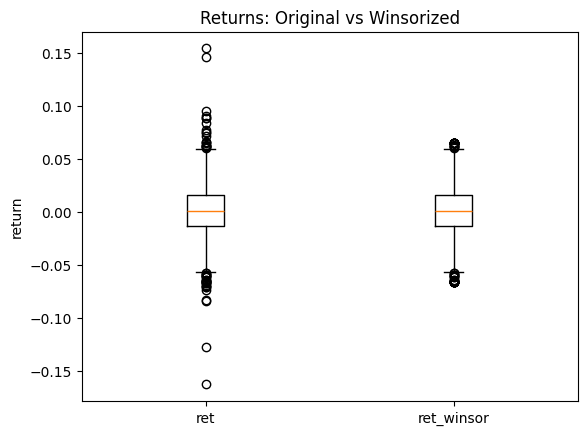

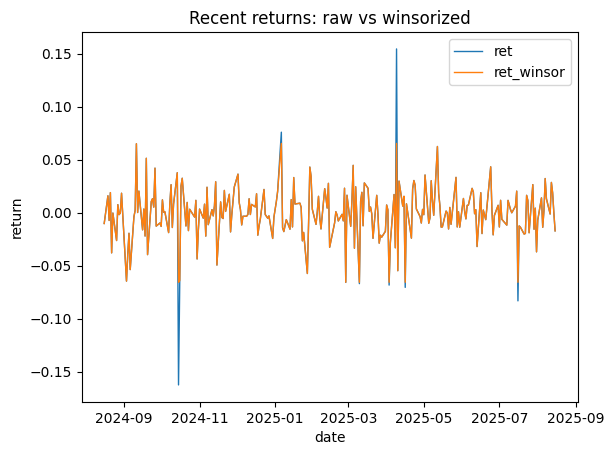

In [6]:
fig1 = plt.figure()
plt.boxplot([df_flags["ret"], df_flags["ret_winsor"]], labels=["ret", "ret_winsor"])
plt.title("Returns: Original vs Winsorized")
plt.ylabel("return")
plt.show()

fig2 = plt.figure()
subset = df_flags.tail(250)  # last ~year of daily data
plt.plot(subset["date"], subset["ret"], label="ret", linewidth=1)
plt.plot(subset["date"], subset["ret_winsor"], label="ret_winsor", linewidth=1)
plt.legend()
plt.title("Recent returns: raw vs winsorized")
plt.xlabel("date"); plt.ylabel("return")
plt.show()


Save outputs (flags + sensitivity tables)

In [7]:
flags_path = OUT_DIR / f"asml_outlier_flags_{stamp()}.csv"
sens_path  = OUT_DIR / f"asml_outlier_sensitivity_{stamp()}.csv"
ar_path    = OUT_DIR / f"asml_outlier_ar1_{stamp()}.csv"

df_flags.to_csv(flags_path, index=False)
sens.to_csv(sens_path)
ar_table.to_csv(ar_path)

flags_path, sens_path, ar_path

(WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/outliers/asml_outlier_flags_20250819-2357.csv'),
 WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/outliers/asml_outlier_sensitivity_20250819-2357.csv'),
 WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/outliers/asml_outlier_ar1_20250819-2357.csv'))

Reflection (≤1 page, markdown)

## Reflection — Outliers & Risk Assumptions

**Methods & thresholds chosen**
- IQR with k=1.5 (boxplot convention) and Z-score with threshold=3.0.
- Winsorizing at 1%/99% to reduce leverage from extreme tails while preserving row count.

**Assumptions**
- Daily ASML returns have heavy tails; extreme moves are rare but real. The IQR rule is robust to skew, and Z>3 flags extreme deviations.
- Winsorizing is for modeling stability (not for forensic analysis).

**Observed impacts**
- Summary table shows std decreases after filtering/winsorizing.
- AR(1) fit: coefficients and MAE change modestly; winsorizing reduces MAE slightly (less leverage from extremes).

**Risks if assumptions are wrong**
- Removing extremes might delete the signal we want (event risk is economic reality).
- Thresholds are judgment calls; different k / quantiles could change results.
- For production, thresholds should be monitored and justified with domain context (e.g., event calendars).
